In [ ]:
!git clone https://github.com/rmcl/modeling-physiology-birdsong.git

Cloning into 'modeling-physiology-birdsong'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 113 (delta 56), reused 88 (delta 31), pack-reused 0 (from 0)
Receiving objects: 100% (113/113), 3.79 MiB | 12.52 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
!cd modeling-physiology-birdsong && git pull

Already up to date.


In [ ]:
!ls modeling-physiology-birdsong

build_histograms_11_12_2024.ipynb     experiment_1_syllable_prob_shift	start-here.ipynb
build_pst_11_13_2024.ipynb	      experiment_2_avg_len_syllable	train_pst_utils.py
check_out_mat_files_11_11_2024.ipynb  Modeling_phys_canary
dataset_parser.py		      pypst


In [ ]:
import sys
sys.path.append('modeling-physiology-birdsong')

In [ ]:
# from dataset_parser import (
#     get_ordered_syllable_for_song,
#     get_recording_time_from_filename,
#     load_single_bird_syllable_csv,
#     split_dataset_by_surgery_date
# )

## No dataset_parser.py, so:

import re
from datetime import datetime
import csv
import json

def get_ordered_syllable_for_song(song_syllable_onsets_offsets_ms):
    """Using syllable_onsets_offsets_ms dictionary return an ordered list of tuples (syllable_label, onset, offset)

    syllable_onsets_offsets_ms (dict)
        key: syllable_label
        value: list of tuples (onset time, offset time)

    Alas python dictionaries are not ordered, so we can't rely on the order of the keys.
    """
    raw_syllable_tuples = []
    for syllable_label, times in song_syllable_onsets_offsets_ms.items():
        for start, end in times:
            raw_syllable_tuples.append((syllable_label, start, end))

    sorted_syllable_tuples = sorted(raw_syllable_tuples, key=lambda x: x[1])
    return sorted_syllable_tuples


def get_recording_time_from_filename(recording_file_path_name):
    """Function to extract animal_id and convert date/time to a datetime object using named groups"""
    try:
        # Define the regex pattern with named groups for animal_id, month, day, hour, minute, and second
        pattern = r'(?P<animal_id>[\w\d]+)_\d+\.\d+_(?P<month>\d+)_(?P<day>\d+)_(?P<hour>\d+)_(?P<minute>\d+)_(?P<second>\d+)\.wav$'

        # Search for the pattern in the file path
        match = re.search(pattern, recording_file_path_name)

        if match:
            # Use the named groups to extract the values
            animal_id = match.group('animal_id')
            month = match.group('month').zfill(2)
            day = match.group('day').zfill(2)
            hour = match.group('hour').zfill(2)
            minute = match.group('minute').zfill(2)
            second = match.group('second').zfill(2)

            # Construct a datetime object (assuming the year is 2024 for this example)
            date_time_str = f"2024-{month}-{day} {hour}:{minute}:{second}"
            date_time_obj = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')

            return animal_id, date_time_obj
        else:
            return None, None  # Return None if no match is found
    except Exception as e:
        print(f"Error: {e}")
        return None, None


def load_single_bird_syllable_csv(file_path):
    """"""
    def unescape_and_eval(v):
        if v.startswith("''"):
            v = v.replace("''", "")
        if v.startswith("'"):
            v = v.replace("'", "")

        return eval(v)

    results = []
    with open(file_path, 'r') as f:
        reader = csv.DictReader(f)

        for row in reader:
            syllable_onsets_offsets_timebins = unescape_and_eval(row['syllable_onsets_offsets_timebins'])
            syllable_onsets_offsets_ms = unescape_and_eval(row['syllable_onsets_offsets_ms'])

            ordered_and_timed_syllables = get_ordered_syllable_for_song(syllable_onsets_offsets_ms)
            animal_id, recording_time = get_recording_time_from_filename(row['file_name'])

            data = {
                "file_name": row['file_name'],
                "song_present": row['song_present'],
                #'syllable_onsets_offsets_timebins': syllable_onsets_offsets_timebins,
                #'syllable_onsets_offsets_ms': syllable_onsets_offsets_ms,

                'animal_id': animal_id,
                'recording_time': recording_time,

                'ordered_and_timed_syllables': ordered_and_timed_syllables
            }

            results.append(data)

    return results

def split_dataset_by_surgery_date(results, surgery_date):
    """Split the dataset into two groups: pre-surgery and post-surgery based on the date of surgery"""
    results_pre_surgery = []
    results_post_surgery = []

    for result in results:
        recording_date = result['recording_time']

        if recording_date < surgery_date:
            results_pre_surgery.append(result)
        elif recording_date == surgery_date:
            raise ValueError("Recording date is the same as the surgery date")
        else:
            results_post_surgery.append(result)

    return results_pre_surgery, results_post_surgery

In [ ]:
import pprint
file_path = 'modeling-physiology-birdsong/Modeling_phys_canary/USA5288_decoded.csv'

results = load_single_bird_syllable_csv(file_path)

print(f'SONGS IN DATASET: {len(results)}')
pprint.pprint(results[1])

import json
from datetime import datetime
json_file_path = 'modeling-physiology-birdsong/Modeling_phys_canary/USA5288_creation_data.json'

with open(json_file_path, 'r') as f:
    data = json.load(f)

    surgery_treatment_date = datetime.strptime(
        data['treatment_date'], '%Y-%m-%d')

print(f'Surgery Treatment Date: {surgery_treatment_date}')

results_pre_surgery, results_post_surgery = split_dataset_by_surgery_date(results, surgery_treatment_date)
print(f'PRE SURG SAMPLES: {len(results_pre_surgery)}, POST SURG SAMPLES: {len(results_post_surgery)}')

SONGS IN DATASET: 52151
{'animal_id': 'USA5288',
 'file_name': 'USA5288_45355.32438532_3_4_9_0_38.wav',
 'ordered_and_timed_syllables': [('8', 0.0, 1813.3333333333335),
                                 ('21', 1813.3333333333335, 3348.730158730159),
                                 ('22', 3348.730158730159, 4425.396825396826),
                                 ('21', 4425.396825396826, 4611.587301587302),
                                 ('22', 4611.587301587302, 4619.68253968254),
                                 ('21', 4619.68253968254, 4622.380952380952),
                                 ('22', 4622.380952380952, 4625.079365079366),
                                 ('21', 4625.079365079366, 4630.476190476191),
                                 ('26', 4630.476190476191, 4751.904761904762),
                                 ('23', 4751.904761904762, 5010.952380952382),
                                 ('2', 5010.952380952382, 5785.396825396826),
                                 ('3', 5785

In [ ]:
def build_song_sequences(dataset):
    song_sequences = []
    for result in dataset:
        if len(result['ordered_and_timed_syllables']) == 0:
            continue

        song_sequences.append([
            str(s[0]) for s in result['ordered_and_timed_syllables']
        ])

    return song_sequences

pre_surgery_sequences = build_song_sequences(results_pre_surgery)
post_surgery_sequences = build_song_sequences(results_post_surgery)

In [ ]:
from pypst import PST

"""
L=7; % maximum order
p_min=.0073; % minimum occurrence probability
g_min=.01; % minimum probability at each node=1.75;
r=1.6; % minimum difference between parent and child node
alpha=17.5;
p_smoothing=0;
"""



def train_pst(sequence_dataset, alphabet=None):

    pst = PST(
        L = 4,
        p_min = .00073, #0.0073,
        g_min = .01,
        r = 1.6,
        alpha = 17.5,
        alphabet = alphabet
    )
    pst.fit(sequence_dataset)

    return pst

pre_surgery_pst = train_pst(pre_surgery_sequences)
alphabet = pre_surgery_pst.alphabet
post_surgery_pst = train_pst(post_surgery_sequences, alphabet=alphabet)

In [ ]:
s = pre_surgery_pst.tree[1]['string']
pre_surgery_pst.tree[1]['parent']
print(pre_surgery_pst.tree[1].keys())
pre_surgery_pst.tree[1]['label']
len(pre_surgery_pst.tree[1]['p']), pre_surgery_pst.tree[2]['p'][1].shape

dict_keys(['string', 'parent', 'label', 'internal', 'g_sigma_s', 'p', 'f'])


(29, (30,))

In [ ]:
order = 2
idx = 3

print(len(pre_surgery_pst.tree[order]['p'][idx]), len(post_surgery_pst.tree[order]['p'][idx]))

trans = pre_surgery_pst.tree[order]['p'][idx]
trans

30 30


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.39286457e-02,
       0.00000000e+00, 1.50320631e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 4.79746694e-05, 6.39662258e-05, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

# Flattened PSTs:

Order 1, Label: ['8'], Probabilities: [0.00000000e+00 1.63645483e-02 1.43297270e-05 1.43297270e-04
 1.43297270e-05 4.29891811e-05 1.14637816e-04 0.00000000e+00
 1.43297270e-05 0.00000000e+00 4.58551265e-04 0.00000000e+00
 4.29891811e-04 7.16486351e-05 0.00000000e+00 0.00000000e+00
 0.00000000e+00 7.16486351e-05 4.29891811e-05 0.00000000e+00
 1.43297270e-05 1.43297270e-05 2.86594540e-05 2.86594540e-05
 0.00000000e+00 1.43297270e-05 3.15253994e-04 1.43297270e-05
 0.00000000e+00 0.00000000e+00]
Order 1, Label: ['21'], Probabilities: [7.16486351e-05 0.00000000e+00 8.87010102e-03 5.76055026e-03
 1.00308089e-04 1.43297270e-05 1.43297270e-05 0.00000000e+00
 2.86594540e-05 0.00000000e+00 1.43297270e-05 0.00000000e+00
 0.00000000e+00 2.86594540e-05 1.43297270e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.43297270e-05 0.00000000e+00
 1.43297270e-05 2.86594540e-05 4.29891811e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
Order

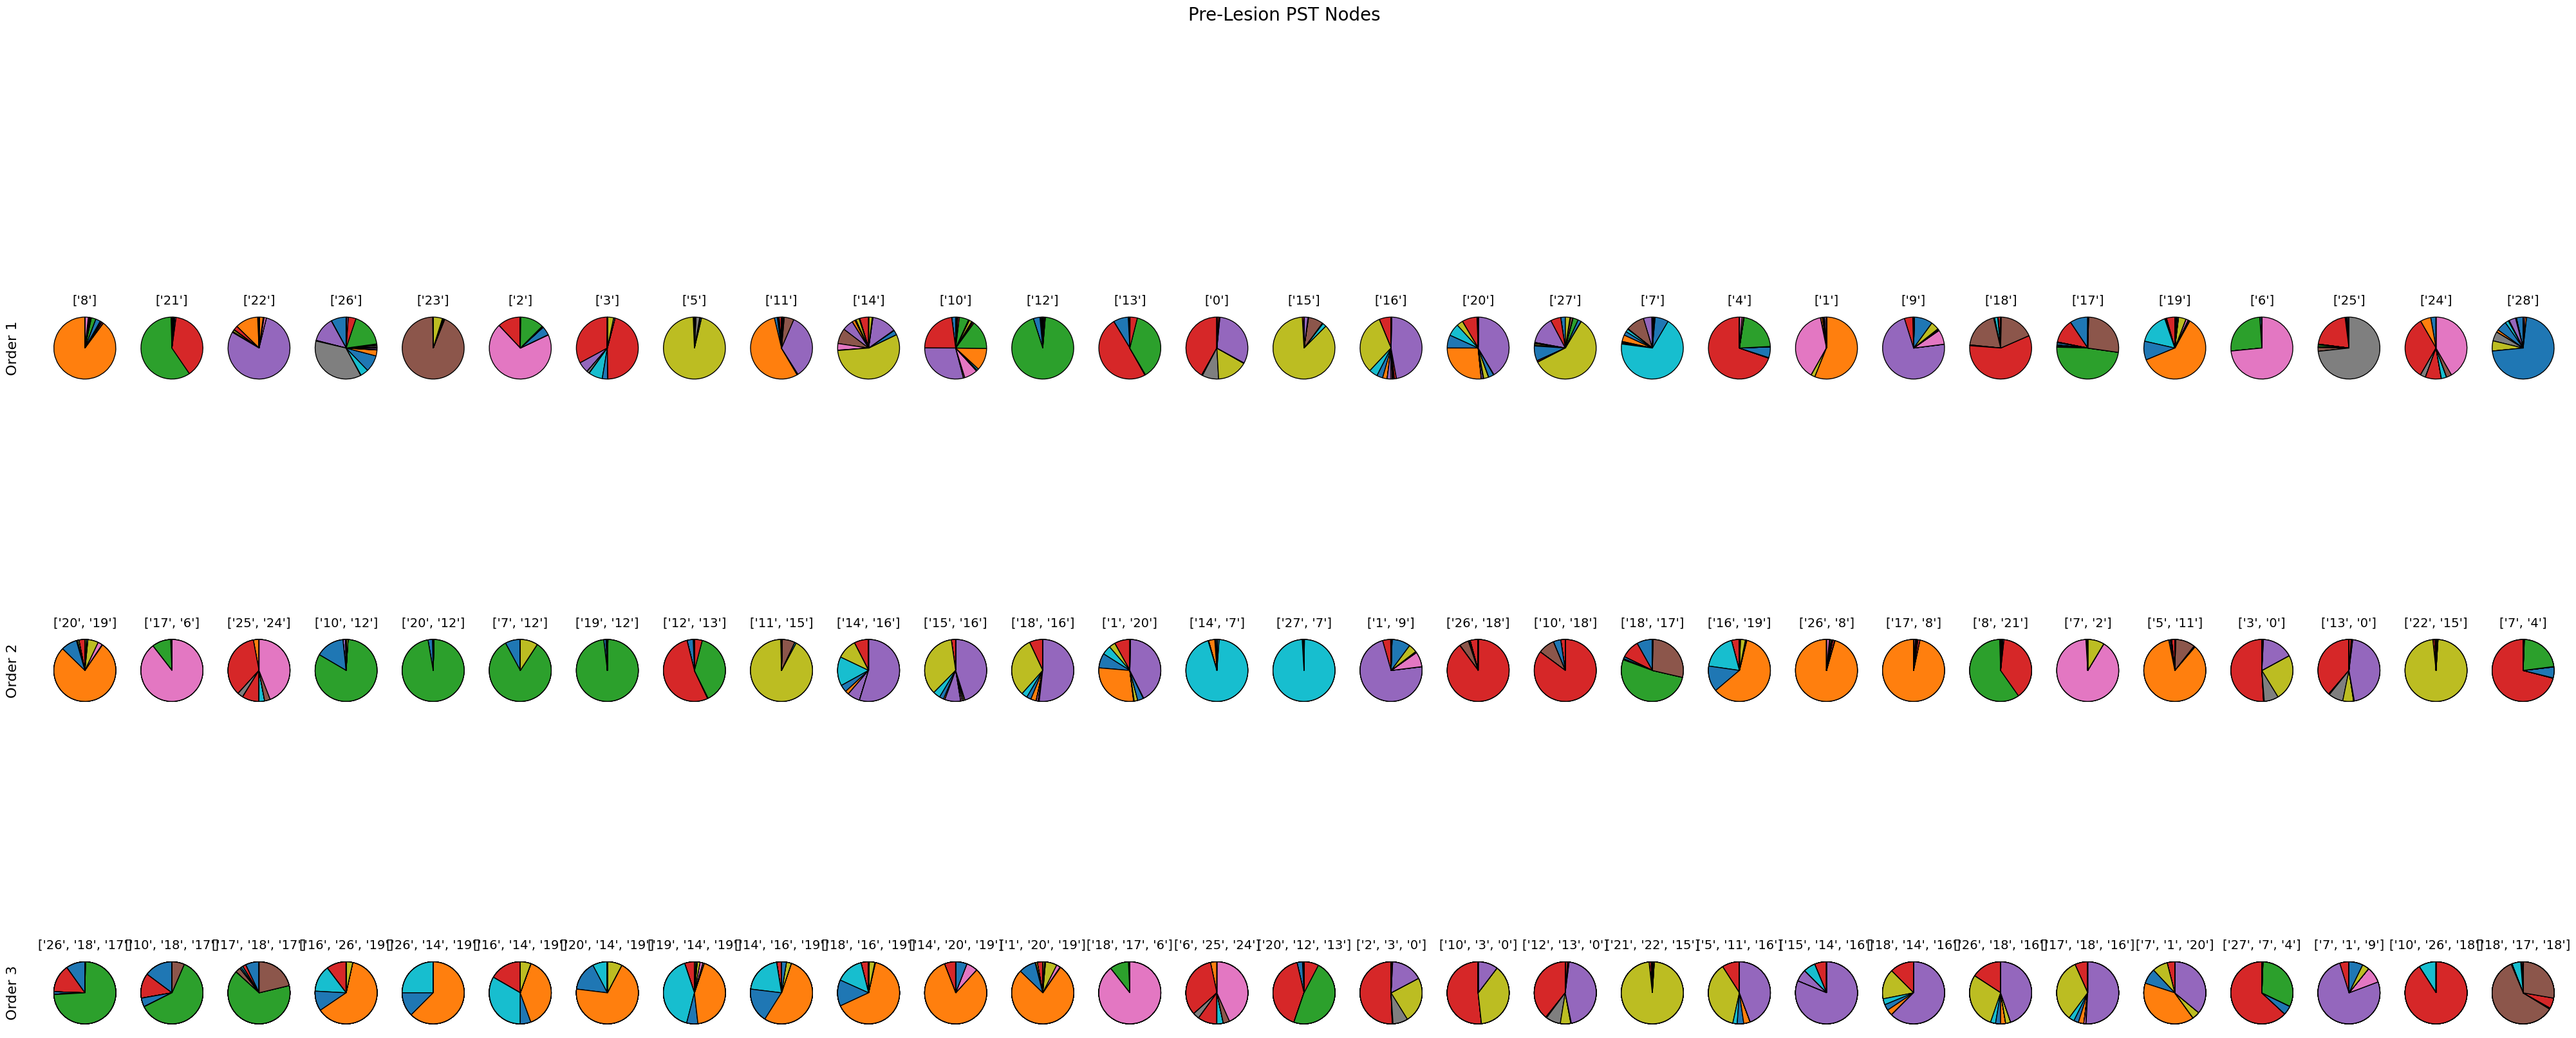

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the number of orders to visualize (1, 2, and 3)
orders_to_visualize = [1, 2, 3]

# Define the length of the alphabet based on the first order of the tree
alphabet_len = len(pre_surgery_pst.tree[1]['label'])

# Create a figure with 3 rows corresponding to orders 1, 2, and 3
fig, axes = plt.subplots(len(orders_to_visualize), alphabet_len, figsize=(40, 20))

# Iterate over each order
for order_idx, order in enumerate(orders_to_visualize):
    # Iterate through the labels for the current order
    for idx, label in enumerate(pre_surgery_pst.tree[order]['label']):
        p = pre_surgery_pst.tree[order]['p'][idx]
        print(f"Order {order}, Label: {label}, Probabilities: {p}")

        # Normalize the probabilities
        total_sum = np.sum(p)
        normalized_data = p / total_sum if total_sum > 0 else np.zeros_like(p)

        # Plot the pie chart in the appropriate position
        axes[order_idx, idx % alphabet_len].pie(
            normalized_data,
            startangle=90,  # Rotate the start angle for better alignment
            wedgeprops={'edgecolor': 'black'}  # Add edge color for clarity
        )
        # Fix: Access the correct element in axes using idx % alphabet_len
        axes[order_idx, idx % alphabet_len].set_title(f'{label}', fontsize=14)

    # Set the order label on the y-axis for the first column in each row
    axes[order_idx, 0].set_ylabel(f'Order {order}', fontsize=16, labelpad=30)

# Hide unused axes if there are any (e.g., if the alphabet has fewer entries)
for ax_row in axes:
    for ax in ax_row[alphabet_len:]:
        ax.remove()  # Remove unused axes

# Add a title to the entire figure
fig.suptitle("Pre-Lesion PST Nodes", fontsize=20)

# Adjust layout for better spacing and avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

# Display the figure
plt.show()


Order 1, Label: ['8'], Probabilities: [0.00000000e+00 6.95712671e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.89880279e-05 2.89880279e-05 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.69640838e-05 0.00000000e+00
 1.15952112e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 2.89880279e-05 8.69640838e-05
 0.00000000e+00 2.89880279e-05 1.73928168e-04 8.69640838e-05
 0.00000000e+00 0.00000000e+00]
Order 1, Label: ['21'], Probabilities: [0.00000000e+00 0.00000000e+00 4.34820419e-04 2.31904224e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.89880279e-05
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.89880279e-05 0.00000000e+00 2.02916196e-04
 0.00000000e+00 0.00000000e+00]
Order

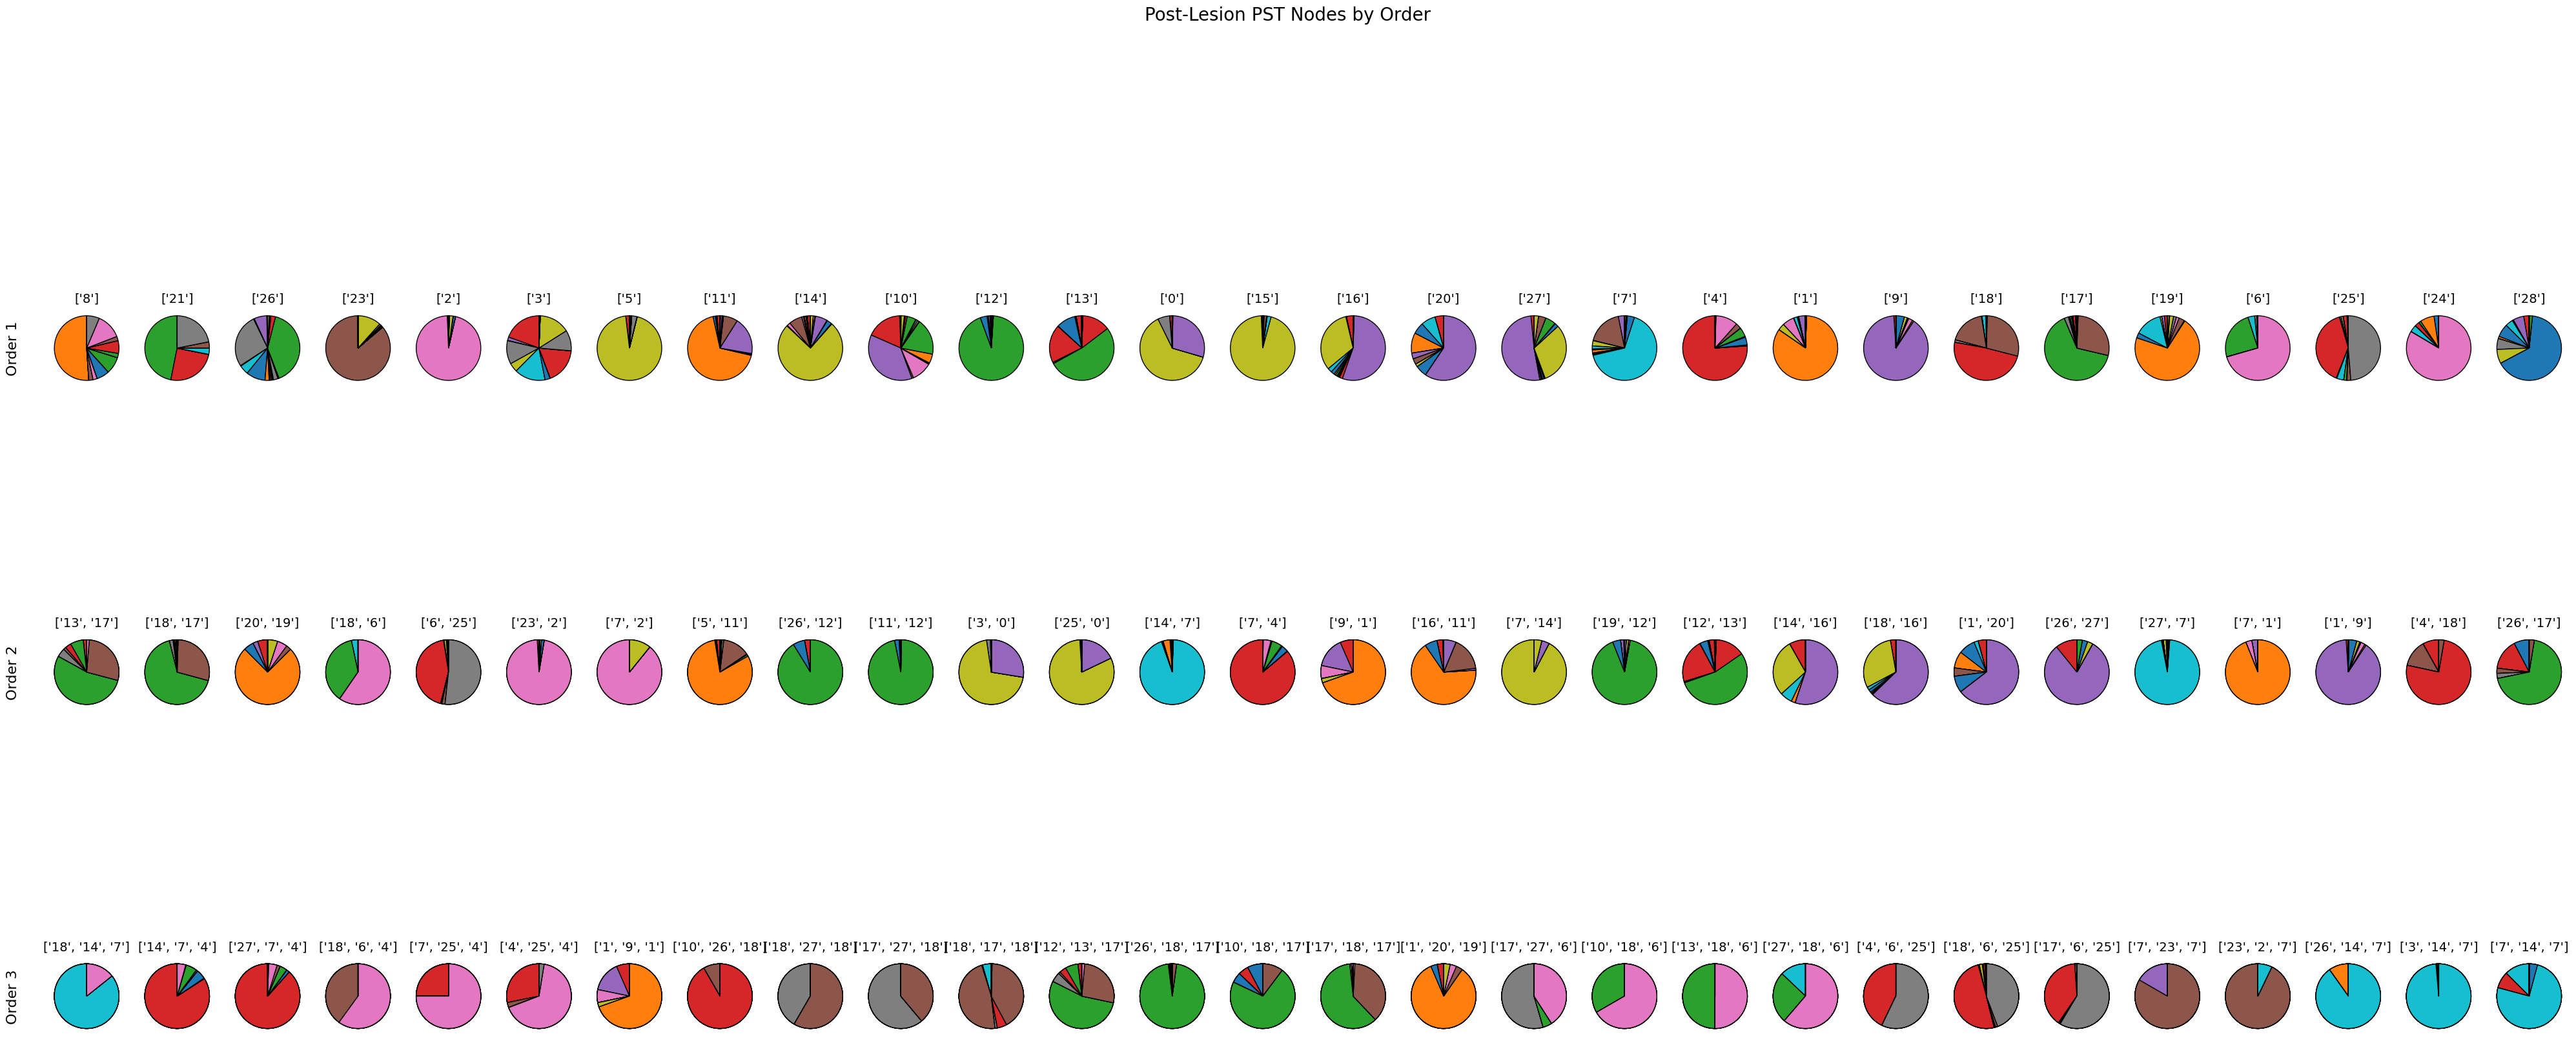

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the number of orders to visualize (1, 2, and 3)
orders_to_visualize = [1, 2, 3]

# Define the length of the alphabet based on the first order of the tree
alphabet_len = len(post_surgery_pst.tree[1]['label'])

# Create a figure with 3 rows corresponding to orders 1, 2, and 3
fig, axes = plt.subplots(len(orders_to_visualize), alphabet_len, figsize=(40, 20))

# Iterate over each order
for order_idx, order in enumerate(orders_to_visualize):
    # Iterate through the labels for the current order
    for idx, label in enumerate(post_surgery_pst.tree[order]['label']):
        p = post_surgery_pst.tree[order]['p'][idx]
        print(f"Order {order}, Label: {label}, Probabilities: {p}")

        # Normalize the probabilities
        total_sum = np.sum(p)
        normalized_data = p / total_sum if total_sum > 0 else np.zeros_like(p)

        # Plot the pie chart in the appropriate position
        axes[order_idx, idx % alphabet_len].pie(
            normalized_data,
            startangle=90,  # Rotate the start angle for better alignment
            wedgeprops={'edgecolor': 'black'}  # Add edge color for clarity
        )
        # Fix: Access the correct element in axes using idx % alphabet_len
        axes[order_idx, idx % alphabet_len].set_title(f'{label}', fontsize=14)

    # Set the order label on the y-axis for the first column in each row
    axes[order_idx, 0].set_ylabel(f'Order {order}', fontsize=16, labelpad=30)

# Hide unused axes if there are any (e.g., if the alphabet has fewer entries)
for ax_row in axes:
    for ax in ax_row[alphabet_len:]:
        ax.remove()  # Remove unused axes

# Add a title to the entire figure
fig.suptitle("Post-Lesion PST Nodes (Ordered)", fontsize=20)

# Adjust layout for better spacing and avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the main title

# Display the figure
plt.show()


# Tree

ValueError: ['10', '2'] is not in list

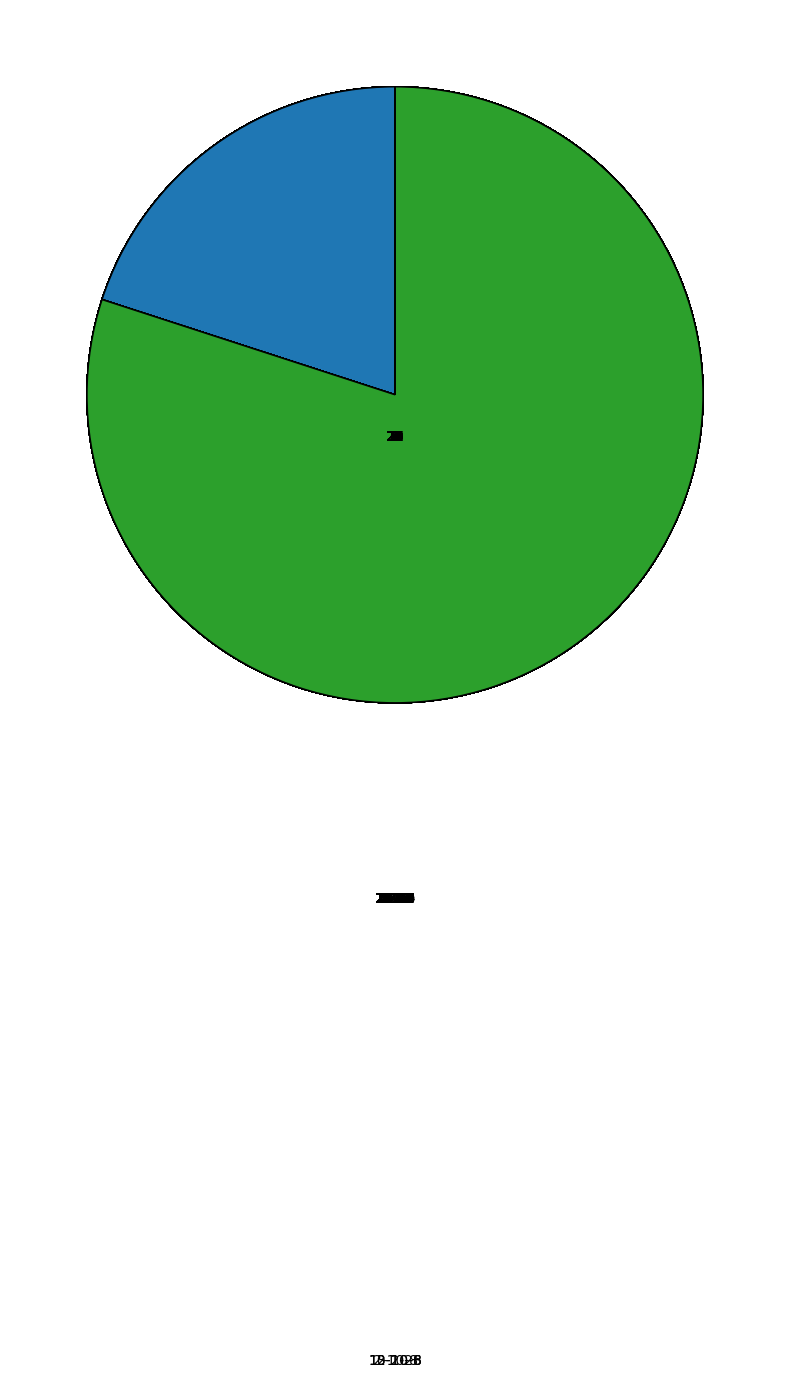

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Function to convert label (list) to string for hashing
def label_to_str(label):
    return '-'.join(map(str, label))

# Recursively build the tree and handle missing parent nodes
def build_tree_recursive(G, pos, label, probabilities, order, y_offset, x_offset=0):
    label_str = label_to_str(label)
    if label_str not in pos:
        # Add the node position if it doesn't exist
        pos[label_str] = (x_offset, y_offset)
        G.add_node(label_str)
        plot_pie(ax, probabilities, pos[label_str], label_str)

    # If the node has a parent, ensure the parent exists before connecting them
    if order > 1:
        parent_label = label[:-1]
        parent_prob = pst_data[order - 1]["p"][pst_data[order - 1]["label"].index(parent_label)]
        parent_label_str = label_to_str(parent_label)

        if parent_label_str not in pos:
            build_tree_recursive(G, pos, parent_label, parent_prob, order - 1, y_offset + 1.5)

        # Add the edge from parent to child
        G.add_edge(parent_label_str, label_str)


# Function to plot pie charts at specific positions
def plot_pie(ax, probabilities, position, label):
    ax.pie(
        probabilities,
        startangle=90,
        wedgeprops={'edgecolor': 'black'}  # Add edge color for clarity
    )
    ax.text(position[0], position[1] - 0.15, label, fontsize=10, ha='center')


# Initialize the plot
fig, ax = plt.subplots(figsize=(12, 10))
ax.axis("off")

# Create a directed graph using NetworkX
G = nx.DiGraph()

# Layout positions for each node
pos = {}
y_offset = 0

# Iterate over each order to build the tree recursively
for order in range(1, 4):
    for idx, label in enumerate(pst_data[order]["label"]):
        probabilities = pst_data[order]["p"][idx]
        normalized_probs = np.array(probabilities) / np.sum(probabilities)
        build_tree_recursive(G, pos, label, normalized_probs, order, y_offset)

    y_offset -= 1.5

# Draw the graph
nx.draw(
    G, pos, ax=ax, arrows=True, edge_color='pink', node_size=0, with_labels=False
)

# Title
plt.title("Prediction Suffix Tree (PST) Visualization", fontsize=16)
plt.show()


# S C R A P S

<ipython-input-26-e29649bbfe18>:92: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


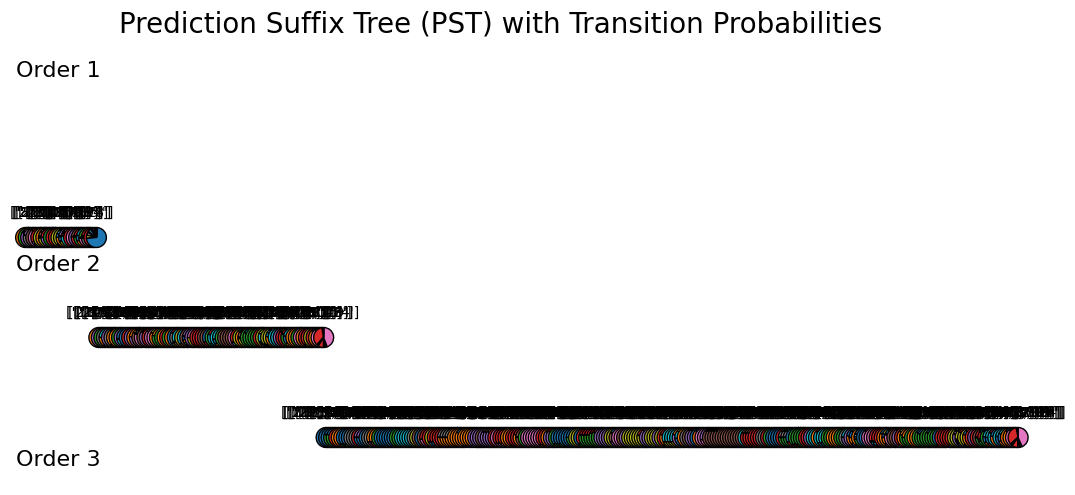

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from matplotlib.patches import FancyArrowPatch


# Initialize an empty directed graph for the PST
pst_graph = nx.DiGraph()

# Define the number of orders to visualize (1, 2, and 3)
orders_to_visualize = [1, 2, 3]

# Define the length of the alphabet based on the first order of the tree
alphabet_len = len(pre_surgery_pst.tree[1]['label'])

# Define node positions for plotting (stacked vertically by order, horizontally by position in the alphabet)
node_positions = {}
node_count = 0
x_offset = 0  # X-coordinate offset for nodes of the same order
node_index_map = {}  # Store a mapping from node name to its index in the tree

# Create the graph nodes and assign positions based on the sequence
for order_idx, order in enumerate(orders_to_visualize):
    for idx, label in enumerate(pre_surgery_pst.tree[order]['label']):
        node_label = f"{label}"
        node_name = f"{node_count}"
        pst_graph.add_node(node_name, label=node_label, order=order)

        # Position nodes: Stack by order, spread horizontally
        node_positions[node_name] = (x_offset, -order_idx)  # (x, y), with negative y to stack downward
        x_offset += 1

        # Store the index of the node in the tree
        node_index_map[node_name] = idx

        node_count += 1

        # Connect child nodes to parent nodes based on sequence order
        if order > 1:
            parent_node = f"{label[:-1]}"  # Parent is the prefix of the current label
            if parent_node in pst_graph:
                pst_graph.add_edge(parent_node, node_name)

# Plot the PST using NetworkX and Matplotlib
fig, ax = plt.subplots(figsize=(10, 5)) # Reduce initial figure size

# Draw the nodes and edges using NetworkX
nx.draw(
    pst_graph,
    pos=node_positions,
    with_labels=False,  # We'll handle the labels separately
    node_size=1000,
    node_color="white",
    edge_color="pink",
    ax=ax
)

# Add pie charts at each node
for node, (x, y) in node_positions.items():
    order = pst_graph.nodes[node]["order"]
    label = pst_graph.nodes[node]["label"]

    # Retrieve transition probabilities using the stored index
    idx = node_index_map[node]  # Get the index from the mapping
    p = pre_surgery_pst.tree[order]['p'][idx]

    total_sum = np.sum(p)
    normalized_data = p / total_sum if total_sum > 0 else np.zeros_like(p)

    # Adjust pie chart positions and sizes to prevent exceeding image size limits
    pie_ax = fig.add_axes([x / (x_offset + 2), y / (len(orders_to_visualize) + 2) + 0.5, 0.05, 0.05], frameon=False)
    pie_ax.pie(
        normalized_data,
        startangle=90,
        wedgeprops={'edgecolor': 'black'},
    )
    pie_ax.set_title(f'{label}', fontsize=10)  # Label as syllable
    pie_ax.axis("off")  # Turn off the axis

# Add order labels to the left of each row
for order_idx, order in enumerate(orders_to_visualize):
    ax.text(-1, -order_idx, f"Order {order}", fontsize=16, ha="right")

# Set plot limits and remove axes
ax.set_xlim(-2, x_offset)
ax.axis('off')

# Add title
fig.suptitle("Prediction Suffix Tree (PST) with Transition Probabilities", fontsize=20)

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


IndexError: list index out of range